# 4. Сверточные нейросети

In [46]:
import pickle

import numpy as np
from CNN import *
from keras.datasets import mnist
from keras.utils import to_categorical

In [47]:
def save_weights(model, filename):
    with open(filename, "wb") as file:
        pickle.dump(model, file)


def load_weights(filename):
    with open(filename, "rb") as file:
        model = pickle.load(file)
    return model


def preprocess_data(x, y, limit):
    x = x.reshape(x.shape[0], 1, 28, 28)
    x = x.astype("float32") / 255
    y = to_categorical(y)
    y = y.reshape(y.shape[0], 10, 1)
    return x[:limit], y[:limit]

In [48]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, y_train.shape[0])
x_test, y_test = preprocess_data(x_test, y_test, y_train.shape[0])

In [49]:
"""
b = (28 - 5 + 1) // 2
c = b - 5 + 1

cnn = CNN(
    loss=binary_cross_entropy,
    loss_derivative=binary_cross_entropy_derivative,
    epochs=5,
    learning_rate=0.1,
)

cnn.add_lay(
    Convolutional(
        input_shape=(1, 28, 28), kernel_size=5, kernels=5, activation="sigmoid"
    )
).add_lay(MaxPooling(pool_size=2)).add_lay(
    Convolutional(input_shape=(5, b, b), kernel_size=5, kernels=3, activation="sigmoid")
).add_lay(
    Reshape(input_shape=(3, c, c), output_shape=(3 * c * c, 1))
).add_lay(
    Dense(input_size=(3 * c * c), output_size=32, activation="sigmoid")
).add_lay(
    Dense(input_size=32, output_size=10, activation="sigmoid")
)

cnn.train(x_train=x_train, y_train=y_train)

save_weights(cnn, "cnn_weights.pkl")
"""

cnn = load_weights("cnn_weights.pkl")


In [50]:
predictions = cnn.test(x_test=x_test, y_test=y_test)


def predictions_to_labels(predictions):
    return predictions.argmax(axis=1)


y_pred = predictions_to_labels(predictions)
y_true = y_test.argmax(axis=1)

## Metrics

$$Accuracy = \frac{TP + TN}{TP + FN + TN + FP}$$
$$Precision = \frac{TP}{TP + FP}$$
$$Recall = \frac{TP}{TP + FN}$$

In [51]:
from typing import List


def accuracy(y_true: List[int], y_pred: List[int], val: int) -> float:
    tp = tn = fp = fn = 0

    for predicted, true in zip(y_pred, y_true):
        if predicted == val and true == val:
            tp += 1
        elif predicted != val and true != val:
            tn += 1
        elif predicted == val and true != val:
            fp += 1
        elif predicted != val and true == val:
            fn += 1

    return (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0


def precision(y_true: List[int], y_pred: List[int], val: int) -> float:
    count_true_positive: int = 0
    count_false_positive: int = 0

    for i in range(len(y_pred)):
        if y_pred[i] == y_true[i] == val:
            count_true_positive += 1
        elif y_pred[i] == val or y_true[i] == val:
            count_false_positive += 1

    return count_true_positive / (count_true_positive + count_false_positive)


def recall(y_true: List[int], y_pred: List[int], val: int) -> float:
    count_true_predicted: int = 0
    false_negative = 0

    for i in range(len(y_pred)):
        if y_pred[i] == y_true[i] == val:
            count_true_predicted += 1
        elif y_true[i] == val:
            false_negative += 1

    return count_true_predicted / (count_true_predicted + false_negative)


for i in range(10):
    print(str(i) + ":")
    print("\taccuracy:  " + str(accuracy(y_true, y_pred, i)))
    print("\tprecision: " + str(precision(y_true, y_pred, i)))
    print("\trecall: " + str(recall(y_true, y_pred, i)))


0:
	accuracy:  0.9924
	precision: 0.9264278799612778
	recall: 0.976530612244898
1:
	accuracy:  0.9928
	precision: 0.9393939393939394
	recall: 0.9832599118942731
2:
	accuracy:  0.9853
	precision: 0.8681614349775785
	recall: 0.937984496124031
3:
	accuracy:  0.9819
	precision: 0.8413672217353199
	recall: 0.9504950495049505
4:
	accuracy:  0.9899
	precision: 0.9020368574199806
	recall: 0.9470468431771895
5:
	accuracy:  0.9863
	precision: 0.8509249183895539
	recall: 0.8766816143497758
6:
	accuracy:  0.9928
	precision: 0.9277833500501504
	recall: 0.965553235908142
7:
	accuracy:  0.9886
	precision: 0.8931583880037488
	recall: 0.9270428015564203
8:
	accuracy:  0.985
	precision: 0.8538011695906432
	recall: 0.8993839835728953
9:
	accuracy:  0.9872
	precision: 0.8805970149253731
	recall: 0.9355797819623389


## Multi-class ROC curve

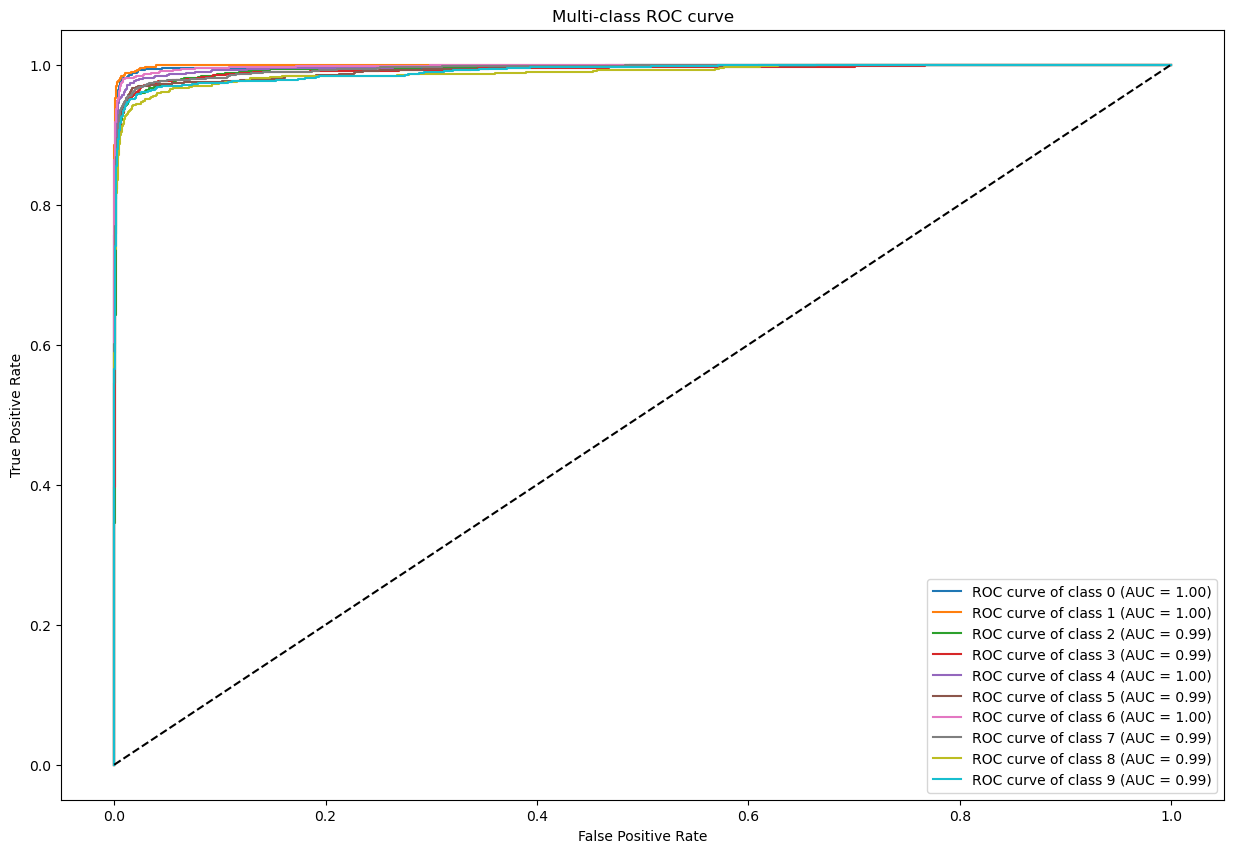

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_true, classes=np.unique(y_true))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(15, 10))
for i in range(10):
    plt.plot(
        fpr[i],
        tpr[i],
        label="ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]),
    )
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC curve")
plt.legend(loc="lower right")
plt.show()